## Twitter Sentiment Analysis for Brand Perception

understanding public sentiment and attitudes towards specific topics or brands in social media is crucial for businesses and organizations

#### Objectives:

* Analyze sentiment patterns: Utilize NLP techniques to perform sentiment analysis on social media text data.
* Visualize sentiment trends: Create informative data visualizations to represent sentiment trends over time.
* Extract insights from the data:Dive deep into the sentiment analysis results to extract valuable insights


In [1]:
# pip install wordcloud


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
# Import useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('punkt')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# create column names
col_names = ['ID', 'Entity', 'Sentiment', 'Content']
# load the data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/folder/twitter_training.csv', names=col_names)
df.head()

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


The columns are:      
``ID``: Unique identifier for each entry  
``Entity``: Entity or brand mentioned in social media content  
``Sentiment``: Sentiment labels (e.g., Positive, Negative, Neutral)  
``Content``: Text content of social media posts

In [10]:
# Check Data Dimensions
df.shape

(74682, 4)

In [11]:
df.dtypes

ID            int64
Entity       object
Sentiment    object
Content      object
dtype: object

### Data Preparation

In [12]:
# check for missing values
df.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      686
dtype: int64

In [13]:
# dropping the rows with content missing values
df.dropna(subset = ['Content'],inplace=True)

In [14]:
# Count the total number of duplicate rows
total_duplicates = df[df.duplicated(keep='first')].shape[0]

print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 2340


In [15]:
# Drop duplicate rows
df.drop_duplicates(keep='first', inplace=True)

# Reset the index after dropping duplicates
df.reset_index(drop=True, inplace=True)

In [16]:
# replace irrelevant to neutral
df['Sentiment'] = df['Sentiment'].replace('Irrelevant', 'Neutral')

### Exploratory Data Analysis (EDA)

 Sentiment distribution

In [17]:
df.Sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

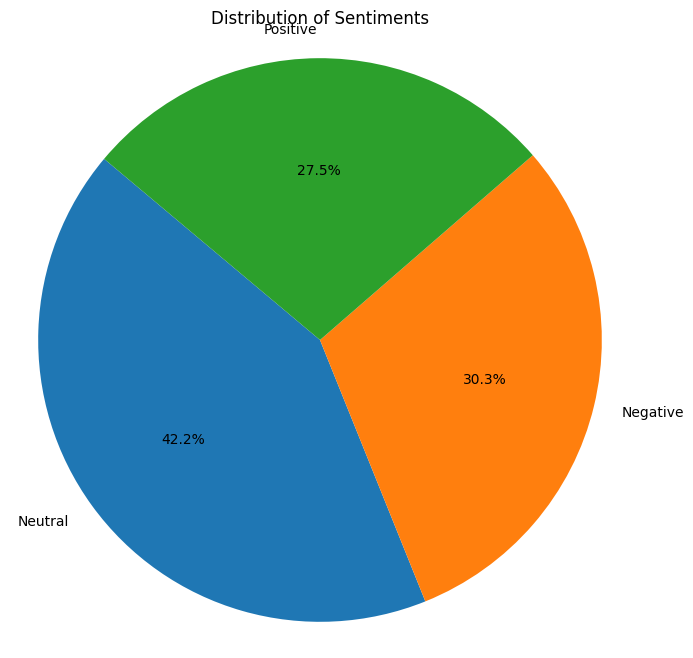

In [18]:
# Calculate the distribution of sentiments
sentiment_distribution = df['Sentiment'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

# Show the pie chart 42.2
plt.show()

Sentiment Distribution Summary

- **Neutral Sentiment:** Approximately 42.2% of sentiments are neutral.
- **Negative Sentiment:** About 30.3% of sentiments are negative.
- **Positive Sentiment:** Around 27.5% of sentiments are positive.

The sentiment distribution is relatively balanced, with neutral sentiments being the most common. This analysis can guide actions such as engaging with neutral sentiments, addressing negative sentiments, and leveraging positive sentiments for marketing and brand promotion.


In [19]:
##### Distribution of Entity

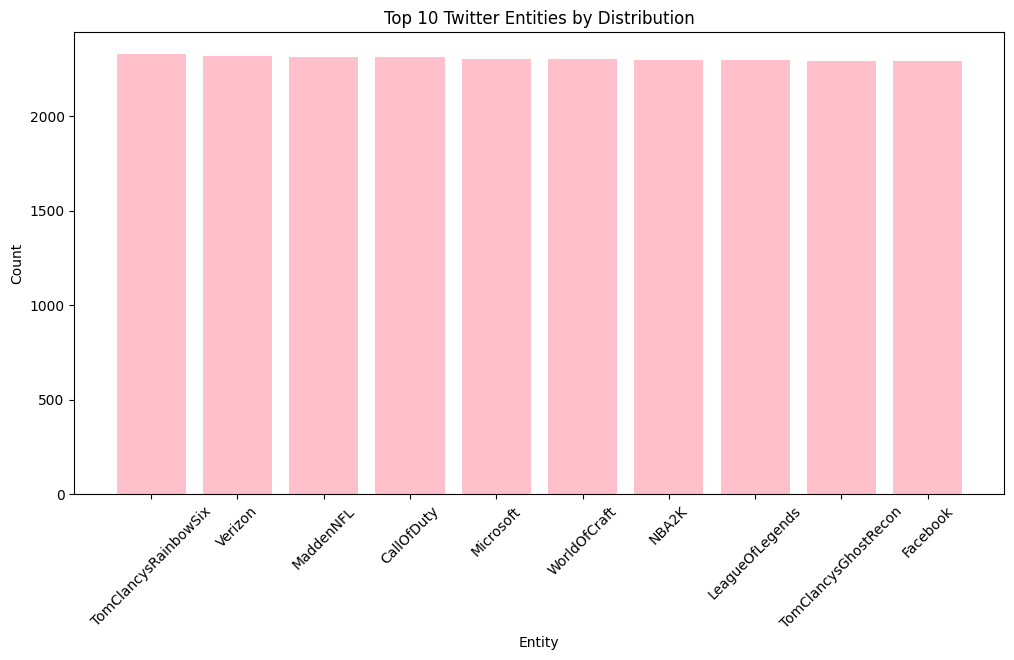

In [20]:
# Calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()

# Select the top 10 entities
top_10_entities = entity_distribution.head(10)

# Create a bar chart for the top 10 entities
plt.figure(figsize=(12, 6))
plt.bar(top_10_entities.index, top_10_entities.values, color='pink')
plt.title('Top 10 Twitter Entities by Distribution')
plt.xlabel('Entity')
plt.ylabel('Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the bar chart
plt.show()

Top Entities 10 entity by distribution is TomClanysRainbow Six

#### Sentiment Distribution in Top 3 Entities

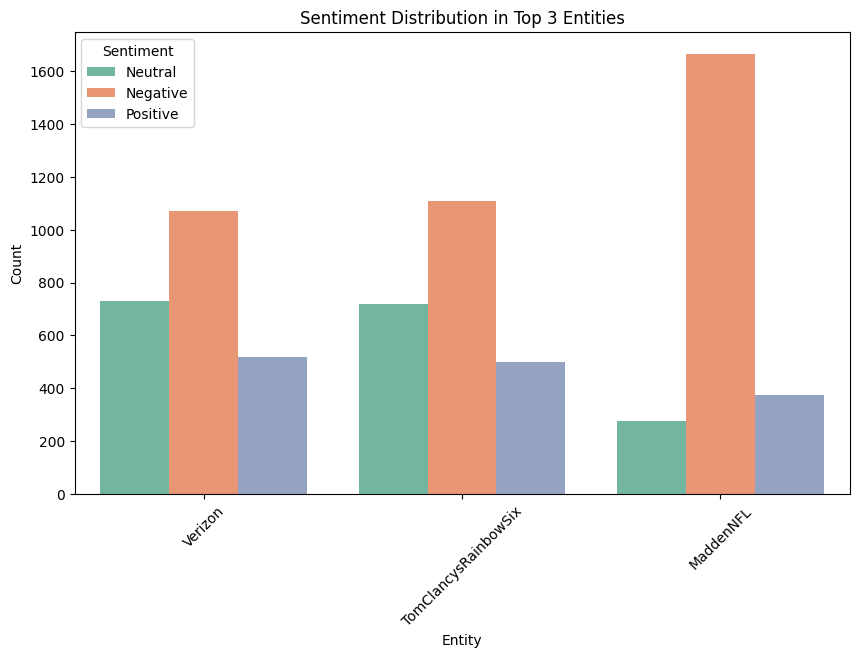

In [21]:
# Calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()

# Select the top 3 entities
top_3_entities = entity_distribution.head(3).index

# Filter the DataFrame to include only the top 3 entities
df_top_3 = df[df['Entity'].isin(top_3_entities)]

# Create a grouped bar chart for sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_3, x='Entity', hue='Sentiment', palette='Set2')
plt.title('Sentiment Distribution in Top 3 Entities')
plt.xlabel('Entity')
plt.ylabel('Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the grouped bar chart
plt.show()

Among the top 3 entities:

- **MaddenNFL:** It has the highest negative sentiment, indicating a notable amount of negative sentiment in conversations related to Madden NFL.
- **TomClancyRainbowSix:** Followed by Tom Clancy's Rainbow Six, which also experiences a significant negative sentiment.
- **Verizon:** Verizon has the highest neutral sentiment, suggesting a more balanced sentiment distribution.




#### Sentiment Distribution Analysis

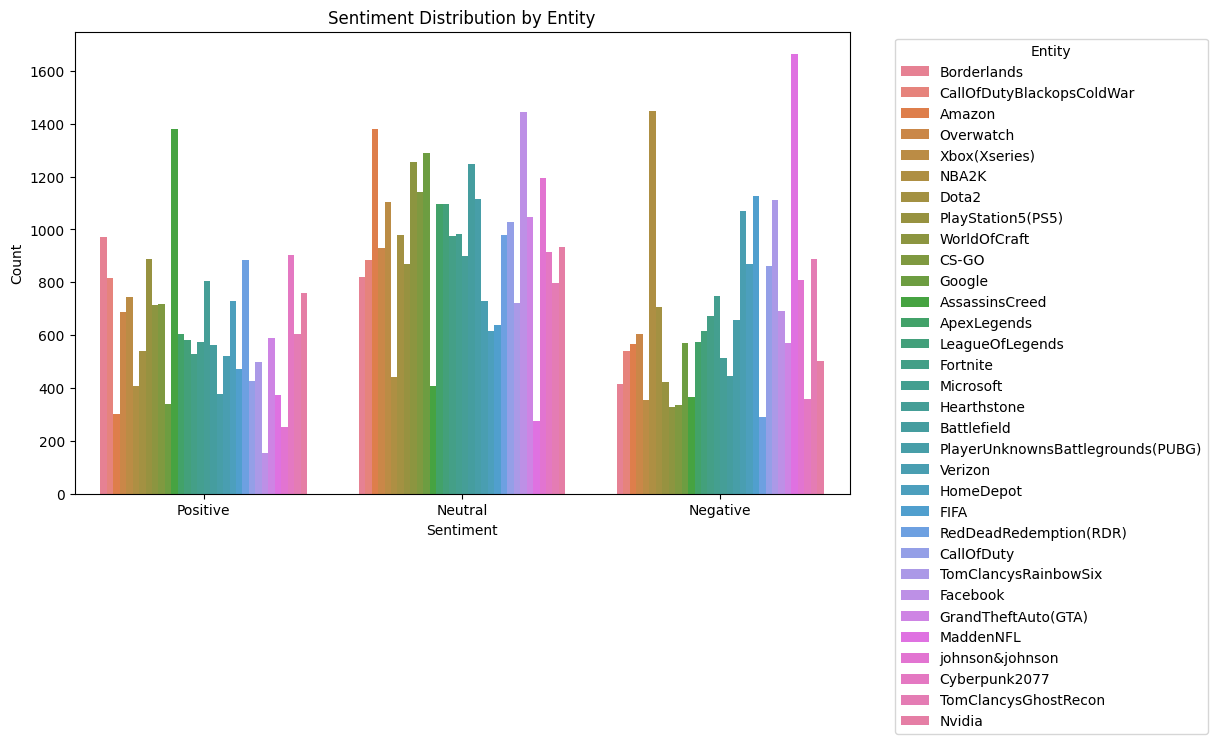

In [22]:
# Example for sentiment distribution by entity
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Sentiment', hue='Entity')
plt.title("Sentiment Distribution by Entity")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(title='Entity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Data Insight:**
- The chart provides a visual overview of how sentiments are distributed among different entities.
- It's evident that sentiment distribution varies by entity, with some entities having a more positive or negative sentiment compared to others.
- This analysis can guide targeted engagement and communication strategies for each entity based on sentiment trends.
- For entities with a high negative sentiment, addressing issues and improving customer satisfaction may be a priority, while entities with a positive sentiment can be leveraged for marketing and brand promotion.

## Text Analysis with NLP Preprocessing

### NLP

The objective of this section is to perform NLP on the text data in order to prepare it for further analysis

In [23]:
# Load NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text with lemmatization and stopwords removal
def preprocess_text(text):
    # Remove special characters, numbers, and links
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()  # Convert to lowercase
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing with lemmatization and stopwords removal to the 'Content' column
df['Cleaned_Content'] = df['Content'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Sentiment Analysis

In [24]:
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer without specifying the lexicon file
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis to the 'Cleaned_Content' column
df['Sentiment_Score'] = df['Cleaned_Content'].apply(get_sentiment_scores)

# Categorize sentiment based on the compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment categorization
df['Sentiment_Predicted'] = df['Sentiment_Score'].apply(categorize_sentiment)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### Distribution of predicted sentiments

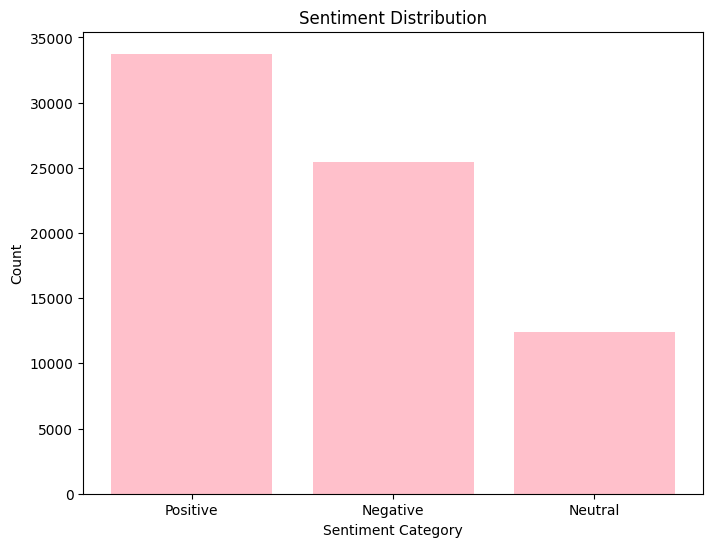

In [25]:
# Calculate the distribution of predicted sentiments
sentiment_distribution = df['Sentiment_Predicted'].value_counts()

# Create a bar chart for sentiment distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color='pink')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

# Show the bar chart
plt.show()

- **Sentiment Categories:** The bar chart illustrates the distribution of predicted sentiments within the social media content. Sentiments are categorized into three main categories: Positive, Negative, and Neutral.
- **User Engagement:** The distribution of sentiment categories reflects the diverse range of opinions and emotions expressed by users on social media platforms. Organizations should consider engaging with users across all sentiment categories to respond to feedback, address concerns, and build positive relationships.
- **Monitoring Sentiment Trends:** Regularly monitoring sentiment distribution can help organizations stay attuned to changes in public sentiment and adjust their strategies accordingly. An increase in negative sentiment, for example, may signal a need for issue resolution or improved communication.
- **Positive Sentiment Prevalence:** The most prevalent sentiment category is "Positive," indicating that a significant portion of the social media content expresses positive opinions or emotions. This suggests that users are actively sharing positive experiences, feedback, or sentiments related to various topics or entities.


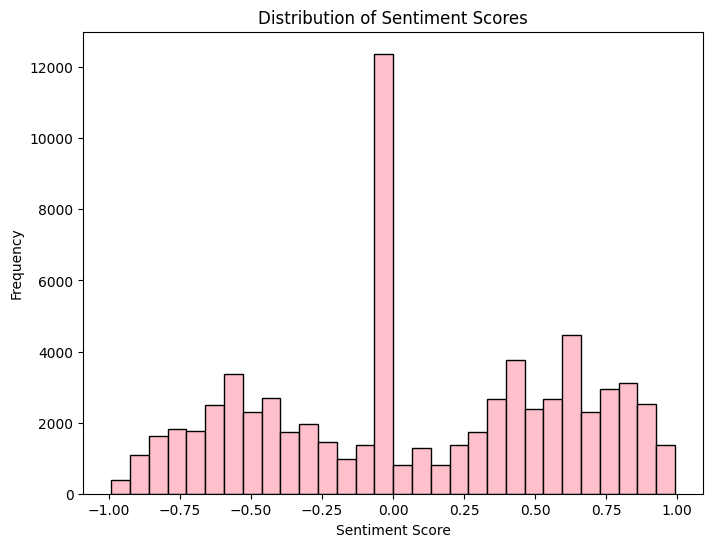

In [26]:
# Create a histogram of sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(df['Sentiment_Score'], bins=30, color='pink', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

## Text Data Analysis

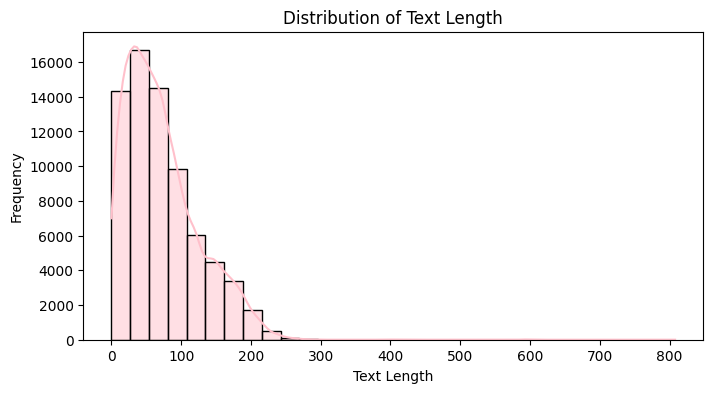

In [27]:
# for text length analysis
df['Text_Length'] = df['Cleaned_Content'].str.len()  # Calculate text length
plt.figure(figsize=(8, 4))
sns.histplot(df['Text_Length'], bins=30,color='pink', edgecolor='black',kde=True)
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

* Peak at Short Texts: The histogram shows that there is a peak in the frequency of short texts. Many tweets are relatively brief in terms of character count.
* Longer Texts Exist: While short texts are prevalent, there is still a range of longer texts present in the dataset, as evidenced by the right tail of the distribution.


#### Word Frequency Analysis

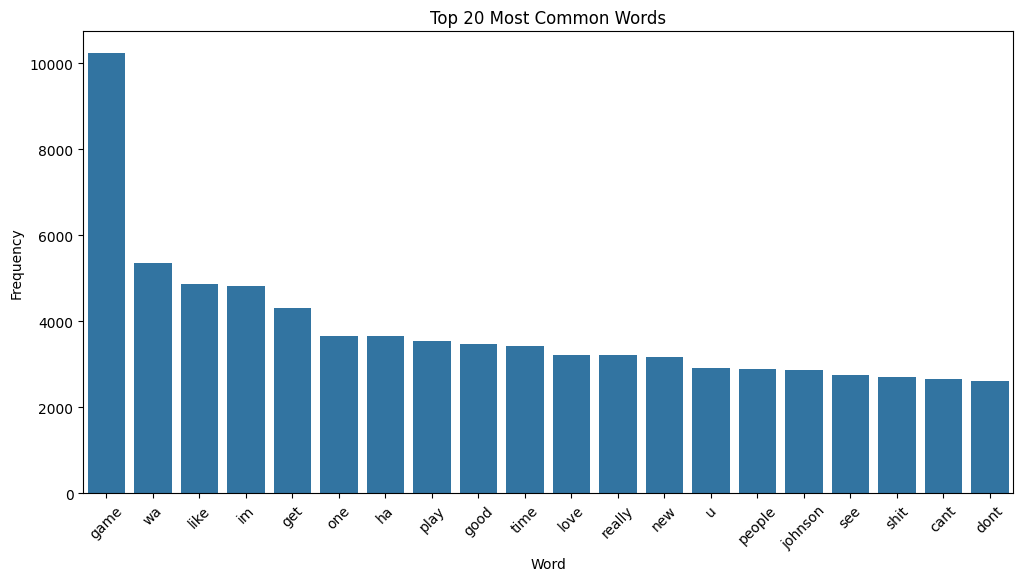

In [28]:
# word frequency analysis
from collections import Counter

words = ' '.join(df['Cleaned_Content']).split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

# Plot the top N most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.title("Top 20 Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


**Insights:**

- **Relevant Keywords:** The most common words now primarily consist of relevant keywords specific to the content since stopwords was removed. Th most frequent word is Game. These words are likely to carry meaningful information about the topics or sentiments discussed.
- **Text Characteristics:** The analysis provides insights into the characteristics of the text data after preprocessing, highlighting frequently occurring terms that are likely to be informative.

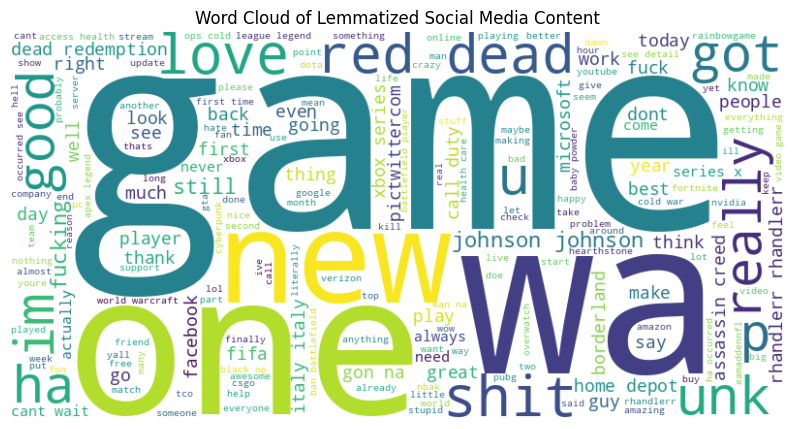

In [30]:
from wordcloud import WordCloud

# Join the lemmatized content into a single string
text_data_lemmatized = ' '.join(df['Cleaned_Content'].dropna())
# Generate a word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_lemmatized)
# plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Lemmatized Social Media Content")
plt.show()


#### Word Cloud for Positive Sentiment

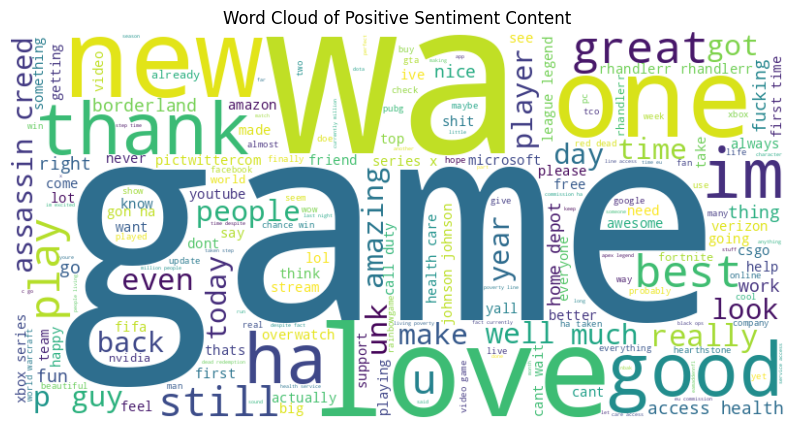

In [32]:
# word cloud for text associated with positive sentiment
# Filter data for positive sentiment
positive_data = df[df['Sentiment_Predicted'] == 'Positive']

# Combine all lemmatized text for positive sentiment
positive_text_data = ' '.join(positive_data['Cleaned_Content'].dropna())

# Generate a word cloud for positive sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text_data)

# Display the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Positive Sentiment Content")
plt.show()




- **Prominent Positive Keywords:** The word cloud prominently displays positive keywords.The most prominent words are "Game", "Wa", "Good", "thank', "new" etc  

The word cloud provides a visual representation of the prevalent themes or topics that evoke positive sentiment among users. These themes may include positive reviews, endorsements, praise, or expressions of satisfaction.

- **Keyword Importance:** By identifying the most common positive keywords, organizations can gain insights into what aspects of their brand, product, or topic resonate positively with their audience. This information can inform marketing strategies and content creation.

- **Engagement Opportunities:** Recognizing the positive sentiment keywords allows organizations to engage with users who express positive opinions. This engagement can further strengthen brand loyalty and foster positive relationships with customers.


#### Word Cloud for Negative Sentiment  
Generate a word cloud for text associated with negative sentiment.

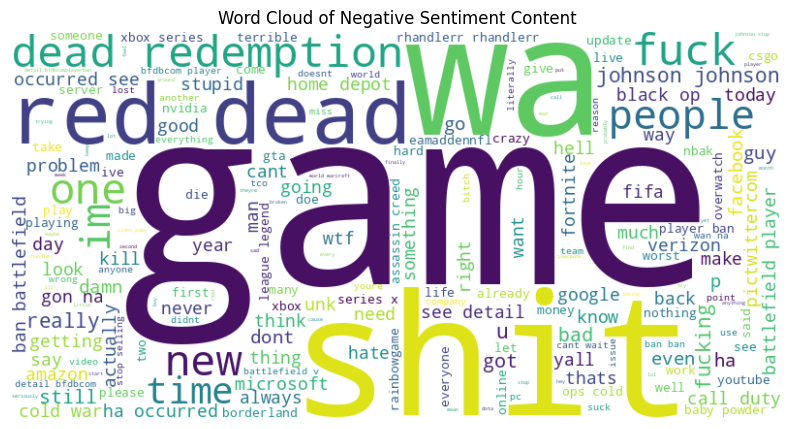

In [33]:
# Filter data for negative sentiment
negative_data = df[df['Sentiment_Predicted'] == 'Negative']

# Combine all lemmatized text for negative sentiment
negative_text_data = ' '.join(negative_data['Cleaned_Content'].dropna())

# Generate a word cloud for negative sentiment
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text_data)

# Display the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Sentiment Content")
plt.show()


- **Negative Themes:** The word cloud provides a visual representation of the prevalent themes or topics that evoke negative sentiment among users. In this case, words like "shit," "game," "wa" (possibly a typographical error), "red," and "dead" stand out as sources of negative sentiment.
- **Keyword Importance:** Identifying the most common negative keywords is crucial for understanding what aspects of a product, brand, or topic are driving negative sentiment. This information can guide improvement efforts and issue resolution.
- **Product Feedback:** Negative sentiment terms like "shit" and "game" may pertain to users' dissatisfaction with specific products or experiences. These insights can help organizations address product concerns.
- **User Feedback:** Recognizing the negative sentiment keywords allows organizations to engage with users who express negative opinions. Responding to and resolving negative feedback can improve brand perception and customer satisfaction.



#### Word Cloud for Neutral Sentiment

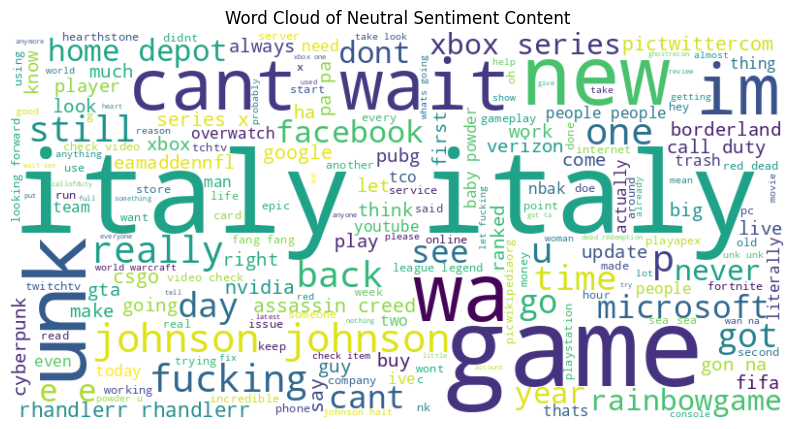

In [34]:
# Filter data for neutral sentiment
neutral_data = df[df['Sentiment_Predicted'] == 'Neutral']

# Combine all lemmatized text for neutral sentiment
neutral_text_data = ' '.join(neutral_data['Cleaned_Content'].dropna())

# Generate a word cloud for neutral sentiment
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text_data)

# Display the word cloud for neutral sentiment
plt.figure(figsize=(10, 6))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Neutral Sentiment Content")
plt.show()


### MODELING

In [35]:
### Data Splitting

# Assign the variables
X = df['Cleaned_Content']  # Features
y = df['Sentiment_Predicted']  # Target
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##### Feature Extraction (Vectorization)

In [36]:

# convert text data into numerical features that can be used by machine learning algorithms using TF-IDF vectorization


tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


#### Model Training

In [37]:

# Initialize the model
model = LogisticRegression(max_iter=1000, solver='saga')

# Train the model
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, solver='saga')

#### Model Evaluation

In [38]:
# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9067820262349986
              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      5066
     Neutral       0.89      0.85      0.87      2471
    Positive       0.92      0.93      0.93      6795

    accuracy                           0.91     14332
   macro avg       0.90      0.89      0.90     14332
weighted avg       0.91      0.91      0.91     14332



The sentiment analysis model showcased remarkable performance across three sentiment categories: Negative, Neutral, and Positive. Here's a concise overview of its performance:

- **Accuracy**: The model achieved an overall accuracy of approximately 90.68%, demonstrating its effectiveness in correctly classifying sentiments.  
- **Precision**: Precision measures the accuracy of positive predictions. The model exhibited precision rates of 90% for Negative, 89% for Neutral, and an impressive 92% for Positive sentiments.   
- **Recall (Sensitivity)**: Recall assesses the model's ability to identify actual positive instances. It achieved recall rates of 90% for Negative, 85% for Neutral, and a strong 93% for Positive sentiments.   
- **F1-Score**: The F1-score, which balances precision and recall, ranged from 87% to 93% across sentiment categories.   
- **Macro and Weighted Averages** : Both macro and weighted averages were around 90% and 91%, respectively, indicating consistent performance across classes and considering class imbalance     

The classification report reveals that the model performs admirably in classifying sentiments across Negative, Neutral, and Positive categories. It demonstrates a balance between precision and recall, with F1-scores ranging from 87% to 93%. Additionally, the high accuracy of 90.68% suggests that the model excels in making correct predictions across sentiment